# Machine Learning Regression on Exploration Soil Sampling Grids

### Continuing on from my most recent piece on mineral prediction mapping, this blog looks at extending exploration soil sampling grids and the regression side of machine learning. The main focus is to explain the process and problems that occur when creating a spatial regression model. It also looks at data preperation, feature selection and the effects of spatial bias.

<img src="Images/Main.png" />

Soil sampling is a widely used exploration tool for understanding the chemical signatures of geology where outcropping bed rock isn't accessible. Through the mediums of gas and water, the chemistry of soil is affected by the underlying bedrock, which can reflect such things as changes in lithology, geological structures and mineral deposits. Soil sampling grids are normally planned as uniform, evenly spaced sample points that cover the extents of an area of interest. The point data is then often interpolated and interpreted to create a geochemical map of the area. 

The purpose of this blog is to interpolate the geochemistry values of an area and to extend the data into areas that have not been sampled by using machine learning. In particular we will look at the Zn values and create a workflow which utilizes a regression model that predicts values of an unknown area, in hope of discovering a mineral deposit. 

<img src="Images/Soil Image.png" />

The location of this study is a small area within in the IOCG endowed Mount Isa block of Queensland, Australia. The data for this example comes from the Queensland Government open source QDEX database and consists of soil sampling assays, geology and airborne imagery/geophysics. All data was visualised and preprocessed in QGIS and python was used for the preprocessing and machine learning stages of this workflow. The study area consists of two sampling grids, one consisting of 165 samples (11x15) and another of 288 samples (12x24) at 100m spacing intervals which can be seen below.

<img src="Images/Study Area.png" />

A common way to visualise soil sampling anomalies and patterns is by creating an interpolation map of the grid, which is dependent on the point values for each sample. Following the work of Anand (2016), the focus element of this workflow will be Zinc, which has been proved anomalous in relation to sulphide mineralisation and hence the potential of base metal deposits. The image below shows the Zn value interpolation over the two sample grids.

<img src="Images/Zn (ppm).png" />

Using the external QDEX data and machine learning, lets see if we can extend the Zn data to the extents of our study boundary. The soil sampling data from QDEX contains an elemental assay suite (some elements missing), the geology consists of lithological and structural data and the geophysics/imagery is comprised of radiometrics, hyperspectral and ASTER (Advanced Spaceborne Thermal Emission and Reflection Radiometer) data. From the geology data, I created 5 features and from the geophysics/imagery I created 14 features for a total of 19 features. For the target variable Zn (and the remaining data) I created a 10m buffer around the points and exported the values as pixel values. The pixels that did not have data were assigned a value of -999 so they are easily distinguishable.

##### Features

Geology
- Lithology - 14 different rock types assigned with individual pixel values
- Distance to Fault - 10m increment values
- Distance to Dyke - 10m increment values
- Distance to Fold - 10m increment values
- Distance to Contact - 10m increment values

Radiometrics [(info)](https://www.ga.gov.au/scientific-topics/disciplines/geophysics/radiometrics)
- U - ppm
- Th - ppm
- K - ppm

ASTER [(info)](https://www.satimagingcorp.com/satellite-sensors/other-satellite-sensors/aster/)
- AlOH Content
- FeO Content 
- Gypsum Content 
- Quartz Index 
- SWIR Water Content

Hyperspectral [(info)](https://www.neonscience.org/hyper-spec-intro)
- Al Smectite 
- Ferric Iron MGOH
- Green Vegetation 
- Kaolin Content 
- Mica Abundance 
- Water Content

The features were all clipped to the study area and exported as grey, single band images comprised of 1020x1040 pixels. The images below are examples of the features and have had colour applied to them for visual purposes. Note that all ASTER and Hyperspectral images have already been processed 

<img src="Images/Grouped.png" />

Now we have all the images saved to file lets plug them into python.

# Importing the data

In this workflow we will use the python packages; numpy, pandas, matplotlib, sklearn and skimage.

In [1]:
#Importing all packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from skimage import io
import rasterio as rio

In [15]:
#Loading Zone Data
Zone = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Soil Zones.tif')

#Loading assay Data
Au = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Au Values.tif')
Bi = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Bi Values.tif')
Cd = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Cd Values.tif')
Co = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Co Values.tif')
Cu = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Cu Values.tif')
Fe = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Fe Values.tif')
Mg = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Mg Values.tif')
Mn = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Mn Values.tif')
Ni = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Ni Values.tif')
P = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/P Values.tif')
Pb = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Pb Values.tif')
S = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/S Values.tif')
Sn = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Sn Values.tif')
Th = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Th Values.tif')
Ti = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Ti Values.tif')
U = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/U Values.tif')
Zn = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Zn Values.tif')
Zr = io.imread('/Users/jackmaughan/SOIL LEARNING/Assay Rasters/Zr Values.tif')

#Loading Hyperspectral Data
H_Al_Smectite = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Al Smectite.tif')
H_Ferric_Iron_MGOH = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Ferric Iron and MgOH.tif')
H_Green_Veg = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Green Vegetation.tif')
H_Kaolin_Content = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Kaolin Content.tif')
H_Mica_Abundance = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Mica Abundance.tif')
H_Water_Content = io.imread('/Users/jackmaughan/SOIL LEARNING/Hyperspectral Rasters/Water Content.tif')

#Loading Radiometric Data
K_Rad = io.imread('/Users/jackmaughan/SOIL LEARNING/Radiometric Rasters/Potassium.tif')
U_Rad = io.imread('/Users/jackmaughan/SOIL LEARNING/Radiometric Rasters/Uranium.tif')
Th_Rad = io.imread('/Users/jackmaughan/SOIL LEARNING/Radiometric Rasters/Thorium.tif')

#Loading Aster Data
A_AlOH_Content = io.imread('/Users/jackmaughan/SOIL LEARNING/Aster Rasters/AlOH Group Content.tif')
A_FeO_Content = io.imread('/Users/jackmaughan/SOIL LEARNING/Aster Rasters/Ferric Oxide Content.tif')
A_Gypsum = io.imread('/Users/jackmaughan/SOIL LEARNING/Aster Rasters/Gypsum Index.tif')
A_Quartz = io.imread('/Users/jackmaughan/SOIL LEARNING/Aster Rasters/Quartz Index.tif')
A_SWIR_Water = io.imread('/Users/jackmaughan/SOIL LEARNING/Aster Rasters/SWIR2 Water.tif')

#Loading Geology Data
Distance_to_Contact = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Distance to Contact.tif')
Distance_to_Dyke = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Distance to Dyke.tif')
Distance_to_Fault = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Distance to Fault.tif')
Distance_to_Fold = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Distance to Fold.tif')
Lithology = io.imread('/Users/jackmaughan/SOIL LEARNING/Geology Rasters/Lithology.tif')

Input_List = [Zone, Au, Bi, Cd, Co, Cu, Fe, Mg, Mn, Ni, P, Pb, S, Sn, Th, Ti, U, Zn, Zr, H_Al_Smectite, 
              H_Ferric_Iron_MGOH, H_Green_Veg, H_Kaolin_Content, H_Mica_Abundance, H_Water_Content, K_Rad, U_Rad,
              Th_Rad, A_AlOH_Content, A_FeO_Content, A_Gypsum, A_Quartz, A_SWIR_Water, Distance_to_Contact, 
              Distance_to_Dyke, Distance_to_Fault, Distance_to_Fold, Lithology]

As the images are have 1020x1040 pixel size, we need to flatten them to be one dimensional. To do this we can use 'for loop' that returns all our images as one dimensional columns so they can be combined into a DataFrame (df).

In [16]:
#Flattening the array shape to be one dimensional
Flat_List = []
for i in Input_List:
    i = i.flatten()
    Flat_List.append(i)

The next step is to create the df. Note that I've included all the other elements and a column called 'Zone'. This is so we can have a look at other elements if we feel like it.

In [17]:
#Creating the main DataFrame for the workflow
df= pd.DataFrame(Flat_List).T
df.columns = ['Zone', 'Au', 'Bi', 'Cd', 'Co', 'Cu', 'Fe', 'Mg', 'Mn', 'Ni', 'P', 'Pb', 'S', 'Sn', 'Th', 'Ti', 
              'U', 'Zn', 'Zr', 'H_Al_Smectite', 'H_Ferric_Iron_MGOH', 'H_Green_Veg', 'H_Kaolin_Content', 
              'H_Mica_Abundance', 'H_Water_Content', 'K_Rad', 'U_Rad', 'Th_Rad', 'A_AlOH_Content', 'A_FeO_Content', 
              'A_Gypsum', 'A_Quartz', 'A_SWIR_Water', 'Distance_to_Contact', 'Distance_to_Dyke', 
              'Distance_to_Fault', 'Distance_to_Fold', 'Lithology']

#Printing first 5 lines of the DataFrame
print(df.head())

   Zone     Au     Bi     Cd     Co     Cu     Fe     Mg     Mn     Ni  ...  \
0   0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
1   0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
2   0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
3   0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   
4   0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  ...   

   A_AlOH_Content  A_FeO_Content  A_Gypsum  A_Quartz  A_SWIR_Water  \
0      245.000000     202.000015       0.0     255.0      0.000008   
1      244.999557     202.000977       0.0     255.0      0.000532   
2      244.984619     202.033264       0.0     255.0      0.017999   
3      244.769089     202.490112       0.0     255.0      0.263755   
4      243.382019     205.343185       0.0     255.0      1.783760   

   Distance_to_Contact  Distance_to_Dyke  Distance_to_Fault  Distance_to_Fold  \
0                280.0 

There is quite a bit of data here, so to make things easier I will save the DataFrame and reload it. This prevents the df from being recreated everytime we alter it and need to revert back to the original.

In [18]:
#Saving df to prevent reloading every time
df.to_pickle('/Users/jackmaughan/SOIL LEARNING/DataFrames/Soil_DataFrame.pkl') 

## Analysis of Data

Now we have the DataFrame ready to go let's do some quick data analysis. This is a very important step and should be a very thorough process, but for the sake of this example we'll just briefly look over it. This [article](https://medium.com/code-heroku/introduction-to-exploratory-data-analysis-eda-c0257f888676) is a great read for understanding and making the most of your data. First lets load the data up from our saved pickle file and have a look at the data types.

In [2]:
#Loading the df
df = pd.read_pickle('/Users/jackmaughan/SOIL LEARNING/DataFrames/Soil_DataFrame.pkl')

In [3]:
#Setting option to view pandas without scientific notation
pd.set_option('float_format', '{:f}'.format)

#Looking at our new data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060800 entries, 0 to 1060799
Data columns (total 38 columns):
Zone                   1060800 non-null float64
Au                     1060800 non-null float64
Bi                     1060800 non-null float64
Cd                     1060800 non-null float64
Co                     1060800 non-null float64
Cu                     1060800 non-null float64
Fe                     1060800 non-null float64
Mg                     1060800 non-null float64
Mn                     1060800 non-null float64
Ni                     1060800 non-null float64
P                      1060800 non-null float64
Pb                     1060800 non-null float64
S                      1060800 non-null float64
Sn                     1060800 non-null float64
Th                     1060800 non-null float64
Ti                     1060800 non-null float64
U                      1060800 non-null float64
Zn                     1060800 non-null float64
Zr                     

Here we can see that all 38 columns were imported into the dataframe with float64 (or numeric) as their data type. This makes sense as the pixel values are numeric in the image files, however, we need to change Zone and Lithology data types to be categorical as they are not numerical in real life.

In [4]:
#Setting Zone and lithology as strings (categoricals)
df['Zone'] = df['Zone'].astype(str)
df['Lithology'] = df['Lithology'].astype(str)

#Viewing all columns
pd.set_option('display.max_columns', None)
df.describe(include = 'all')

,Zone,Au,Bi,Cd,Co,Cu,Fe,Mg,Mn,Ni,P,Pb,S,Sn,Th,Ti,U,Zn,Zr,H_Al_Smectite,H_Ferric_Iron_MGOH,H_Green_Veg,H_Kaolin_Content,H_Mica_Abundance,H_Water_Content,K_Rad,U_Rad,Th_Rad,A_AlOH_Content,A_FeO_Content,A_Gypsum,A_Quartz,A_SWIR_Water,Distance_to_Contact,Distance_to_Dyke,Distance_to_Fault,Distance_to_Fold,Lithology
count,1060800,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800.000000,1060800
unique,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7
top,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0
freq,1056064,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,533415
mean,NaN,-994.464540,-994.538846,-994.539814,-994.421833,-994.218797,-994.508155,-945.285950,-990.398006,-994.397298,-991.550722,-994.514244,-993.769830,-994.530378,-994.476048,-973.013250,-994.523175,-994.467626,-993.682085,4.548567,9.468350,54.735404,6.324279,4.301724,4.192148,2.259082,2.250257,12.388161,190.402090,216.273739,0.498279,136.019765,33.278360,230.938622,711.643684,412.105317,1300.713084,NaN
std,NaN,67.918260,66.617245,66.602797,68.377610,72.086867,67.075887,940.110438,144.857130,68.734918,117.293371,66.985184,80.089137,66.743716,67.555685,403.474942,66.851467,67.683633,79.476939,13.414262,18.124056,46.054800,16.264993,11.623670,9.515758,0.608927,0.849881,3.223545,67.115788,53.640816,0.685528,96.294112,45.531163,202.143386,536.026600,362.867557,856.145252,NaN
min,NaN,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.006305,0.000000,0.000000,0.000000,0.662488,0.481173,5.627954,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,10.000000,10.000000,NaN
25%,NaN,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.838669,1.373883,19.926618,0.922456,0.892640,0.934837,1.820036,1.649962,9.886083,161.657722,207.372231,0.000000,37.439573,4.822430,70.000000,320.000000,130.000000,520.000000,NaN
50%,NaN,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,1.494332,2.762921,41.928646,1.606380,1.561652,1.562366,2.144770,2.165841,11.959446,217.747360,238.530144,0.210211,145.928040,16.739423,170.000000,600.000000,310.000000,1240.000000,NaN
75%,NaN,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,2.349503,8.236799,76.770369,2.884653,2.530773,2.687651,2.627133,2.694848,14.370506,239.778973,249.489059,1.000000,240.000290,38.905553,340.000000,930.000000,590.000000,1970.000000,NaN


Now we have all the data set to the correct type we can have a look at it a bit more intensely. Looking at the assay data we can see that the mean is -994. This is because we have so much unknown data that it is heavily skewed. We need to filter out the unknown values if we want to properly assess the chemistry. Also, the hyperspectral data has a noticeably high 'max' value compared to its 'mean'. We can plot this up in a histogram, using Kaolin Content as an example, to visualise the data distribution.

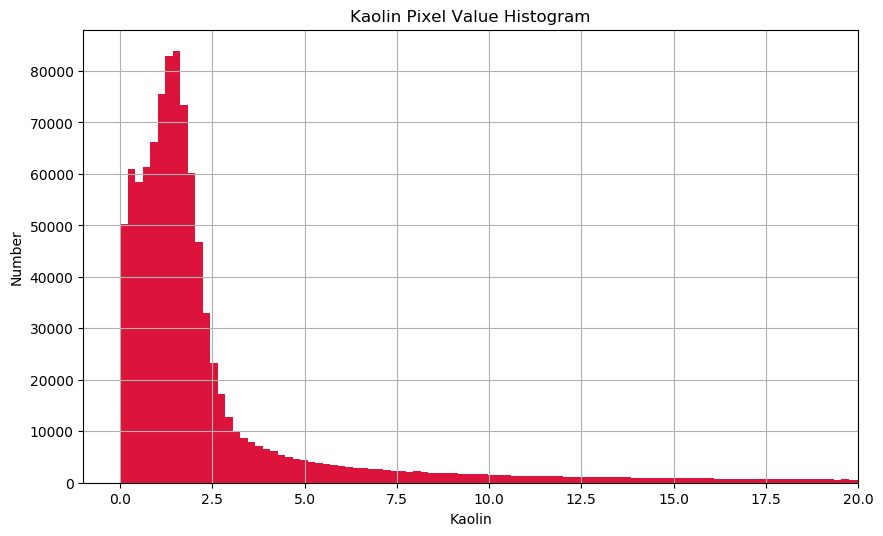

In [5]:
#Plotting the histogram of Kaolin Content
figure(num=None, figsize=(10, 6), dpi=100)
df['H_Kaolin_Content'].plot(kind='hist', bins=1000, color='crimson', )
plt.xlabel('Kaolin')
plt.ylabel('Number')
plt.title('Kaolin Pixel Value Histogram')
plt.xlim(-1,20)
plt.grid()
plt.show()

Here we can see that the majority of data for the Kaolin Content feature is between 0-3 and it becomes quite sparse after that. It is important to know that the data is not normally distributed when it comes to gaining correlation information of features, which we will do now. Firstly we will split the df to just look at the areas where we have assay values and look at the 20 best correlated features.

In [6]:
#Load up only the areas we are going to model
df=df[df['Zn']!=(-999)]

#Removes the self-correlated pairs
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#Looks at the top correlations
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method='spearman').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

#Analysing the top 20 correlations of our DataFrame
get_top_abs_correlations(df.drop(['Zone', 'Lithology'], axis=1), 20)

Bi                Pb                 0.740089
Co                Ni                 0.732013
                  Fe                 0.726460
K_Rad             Th_Rad             0.721683
Co                Cu                 0.717990
Bi                Cu                 0.651565
                  U                  0.617995
Pb                U                  0.579971
Co                Th_Rad             0.546472
Bi                Th_Rad             0.538697
Cu                Fe                 0.536083
Bi                Co                 0.526573
Fe                Ni                 0.522018
H_Mica_Abundance  H_Water_Content    0.521053
Th_Rad            Distance_to_Fold   0.496708
Mn                Pb                 0.475030
Cu                Ni                 0.474575
Cd                Pb                 0.460401
Cu                Pb                 0.458016
Fe                Th_Rad             0.456795
dtype: float64

This shows us the first 20 features with the strongest correlatation for our soil sample point area. The assay data seems to be well correlated to each other (in particular the base metals), and so does the K and Th radiometric data, which makes sense. Notice that the correlation method was set to 'Spearman', this is because the data is not normally distributed, more on that [here](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365). 

So now we have our data types converted and split the data into where values are known what other preproccessing could we do?

- Ammend Missing values - As we have working with images none of our features are missing data, so nothing to worry about here.
- Remove Outliers - We could look at removing outliers, but in the sense of mineral exploration outliers or anomalies could be a good thing. So we'll keep them in.
- Feature Scaling - Scaling our features could help our model performance, but this is dependent on the model. For this example we will use Random Forest Regression and therefore do not need to scale our features. More info on that [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e)

## Feature Selection

A big part of creating a good model is deciding what features it is built from. There are many different ways to view what features are important when predicting/classifying your target variable (learn more [here](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)) but we will use a relatively simple one. Similarly to what we did earlier, we will look at how well the features are correlated, except this time we will look at how the features correlate to the Zn values. First we need to remove the other elements and just look at our training features.

In [7]:
#removing other elements 
df = df.drop(['Au', 'Bi', 'Cd', 'Co', 'Cu', 'Fe', 'Mg', 'Mn', 'Ni', 'P', 'Pb', 'S', 'Sn', 'Th', 'Ti', 'U', 'Zr'], axis=1)

corr = df.corr(method='spearman')
cor_target = abs(corr['Zn'])

cor_target.sort_values(ascending=False)

Zn                    1.000000
Distance_to_Fault     0.228624
A_Quartz              0.174744
Distance_to_Dyke      0.170363
K_Rad                 0.164062
Distance_to_Fold      0.154464
H_Ferric_Iron_MGOH    0.097376
A_Gypsum              0.096027
A_FeO_Content         0.091321
H_Green_Veg           0.076864
A_SWIR_Water          0.063393
A_AlOH_Content        0.046846
H_Al_Smectite         0.043912
Th_Rad                0.019784
H_Mica_Abundance      0.017317
U_Rad                 0.013903
H_Kaolin_Content      0.005134
H_Water_Content       0.002771
Distance_to_Contact   0.000005
Name: Zn, dtype: float64

Here we can see how well the 18 numeric features correlate to the Zn target variable. Notice that Lithology does not have a correlation coefficient because it is a categorical feature and this process only analyses numerical features. Some features have different effects on how your model learns and understanding which are the right ones is an important process, but (again cutting corners) for this example I've selected the 9 most correlated features and our lithology feature.

<img src="Images/KetchuporCatsup.jpg" />

More intense feature selection methods can be read about [here](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b) and [here](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b). Let's filter out the desired features and start making some models.

In [8]:
#Filtering out to contain the desired features
df=df.filter(['Zn', 'Distance_to_Fault', 'A_Quartz', 'Distance_to_Dyke', 'K_Rad', 'Distance_to_Fold', 'H_Ferric_Iron_MGOH', 'A_Gypsum', 'A_FeO_Content', 'H_Green_Veg', 'Lithology'], axis=1)

## Model Creation

In this example we will use the Random Forest Regression algorithm from Sklearn for our model. Let's take a quick trip to the carnival first and look at the difference between Classification and Regression algorithms. Both classification and regression are forms of supverised learning, but with a major difference. Classification models predict categories/classes and regression models predict numeric data/values. In my last blog we used a classifiaction model to predict whether areas had >0.8g/t gold or whether they didn't (two classes). In this blog we're trying to predict the Zn values of areas that we don't have soil data for, so we want to use a regression algorithm.

<img src="Images/ClownClassification.png" />

First let's use a random test/train split on all the Zn data we have and see how accurate we can get our model.

In [9]:
#Splitting our target variable and our features
y = np.array(df.pop('Zn').values)
X = np.array(df)

In [10]:
#Running a train/test split on the whole dataset. The test data is split as 1/3 of our total data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now we have our data split lets try and tune our parameters using a grid search.

In [11]:
#Creating our inital test classifier
RF = RandomForestRegressor()

#Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
grid_param_RF = {
    'bootstrap': [True],
    'max_depth': [50, 75, 100, 150, 200, 500],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [10, 25, 50, 100, 200]}

gd_sr_RF = GridSearchCV(estimator = RF, param_grid = grid_param_RF, cv = 3, n_jobs = -1)
gd_sr_RF.fit(X_train, y_train)

#Assigning a variable to the best paramaters and the classification accuracy
print(gd_sr_RF.best_params_)

{'bootstrap': True, 'max_depth': 75, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 25}


Using these parameters lets apply them to our test data and see how our model looks.

In [12]:
#Adjusting our model parameters and fitting them to our test/train data
RF = RandomForestRegressor(bootstrap= True, max_depth=75, min_samples_leaf=2, min_samples_split=3, n_estimators=25)
RF.fit(X_train, y_train)

#Returning our prediction values for the test data
y_pred = RF.predict(X_test)

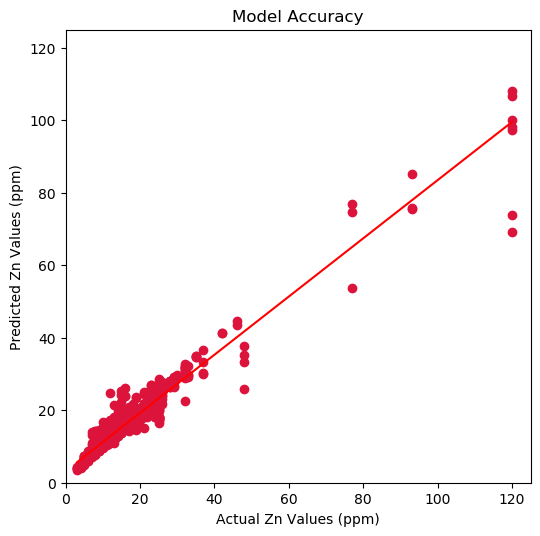

In [13]:
#Combining the actual and predicted values into a single df
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

#Plotting actual vs predicted values
figure(num=None, figsize=(6, 6), dpi=100)
plt.scatter(df_results['Actual'], df_results['Predicted'], color='crimson')
plt.xlabel('Actual Zn Values (ppm)')
plt.ylabel('Predicted Zn Values (ppm)')
plt.title('Model Accuracy')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')

plt.show()

<img src="Images/1.png" />

In [168]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.984216448831612
Mean Squared Error: 6.748162165083903
Root Mean Squared Error: 2.597722495780468
R2 Score: 0.9358075652915981


Wheyy not bad. Looking at the graph we can see that the majority or predicted values are quite close to their actual values, with the higher values of Zn being a bit harder to predict. However, this is a good looking model with some good evalution metrics seen in the MSE and R^2 Score. More on what those values represent [here](https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/).

One thing to take into account however, is the spatial bias. If you look at the test/train points in the image you'll see that the test data is spatially random amongst known values. Implementing the model in the real world doesn't work like this. Following this [explanation](https://medium.com/@thomaslcarmichael/spatial-bias-and-machine-learning-ce4f5d96258c) we will see if we can recreate the models accuracy if we split the train/test data into seperate spatial zones.

### Zone Training

As seen in the image below, I have split the 2 soil sampling grids into 3 seperate grids. The zone data has already been imported into our df as mentioned before and can be used to split our data.

<img src="Images/Zones_Labelled.png" />

In the next couple of steps we will reload the DataFrame, preprocess the data and split the df into zones.

In [16]:
#Reloading dataframe
df = pd.read_pickle('/Users/jackmaughan/SOIL LEARNING/DataFrames/Soil_DataFrame.pkl')

#Setting the same datatypes
df['Zone'] = df['Zone'].astype(str)
df['Lithology'] = df['Lithology'].astype(str)

#Splitting into seperate dataframes
df_Zone1=df[df['Zone']==('1.0')]
df_Zone2=df[df['Zone']==('2.0')]
df_Zone3=df[df['Zone']==('3.0')]

#Putting all zone data in uniform order
df_Zone1=df_Zone1.filter(['Zn', 'Distance_to_Fault', 'A_Quartz', 'Distance_to_Dyke', 'K_Rad', 'Distance_to_Fold', 'H_Ferric_Iron_MGOH', 'A_Gypsum', 'A_FeO_Content', 'H_Green_Veg', 'Lithology'], axis=1)
df_Zone2=df_Zone2.filter(['Zn', 'Distance_to_Fault', 'A_Quartz', 'Distance_to_Dyke', 'K_Rad', 'Distance_to_Fold', 'H_Ferric_Iron_MGOH', 'A_Gypsum', 'A_FeO_Content', 'H_Green_Veg', 'Lithology'], axis=1)
df_Zone3=df_Zone3.filter(['Zn', 'Distance_to_Fault', 'A_Quartz', 'Distance_to_Dyke', 'K_Rad', 'Distance_to_Fold', 'H_Ferric_Iron_MGOH', 'A_Gypsum', 'A_FeO_Content', 'H_Green_Veg', 'Lithology'], axis=1)

In [17]:
#Splitting the features and target variable for each othe zones
y_zone1 = np.array(df_Zone1.pop('Zn').values)
X_zone1 = np.array(df_Zone1)

y_zone2 = np.array(df_Zone2.pop('Zn').values)
X_zone2 = np.array(df_Zone2)

y_zone3 = np.array(df_Zone3.pop('Zn').values)
X_zone3 = np.array(df_Zone3)

##### Zone 3 Train - Zone 2 Test

First lets try to make a model from the data in zone 3 and test it on the data from zone 2.

In [18]:
#Fitting the model
RF_zone3 = RandomForestRegressor(bootstrap= True, max_depth=75, min_samples_leaf=2, min_samples_split=3, n_estimators=25)
RF_zone3.fit(X_zone3, y_zone3)

#Returning the prediction values for the zone 2
y_zone2_pred = RF_zone3.predict(X_zone2)

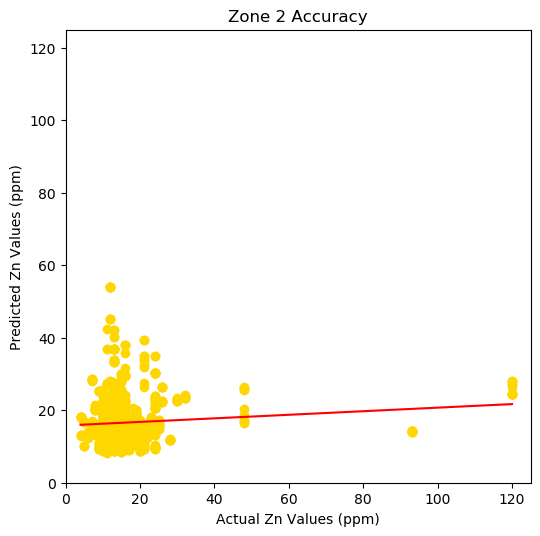

In [19]:
#Combining actual and predicted values into a DataFrame
df_results = pd.DataFrame({'Actual': y_zone2, 'Predicted': y_zone2_pred})

#Plotting actual vs predicted values
figure(num=None, figsize=(6, 6), dpi=100)
plt.scatter(df_results['Actual'], df_results['Predicted'], color='gold')
plt.xlabel('Actual Zn Values (ppm)')
plt.ylabel('Predicted Zn Values (ppm)')
plt.title('Zone 2 Accuracy')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.plot(np.unique(y_zone2), np.poly1d(np.polyfit(y_zone2, y_zone2_pred, 1))(np.unique(y_zone2)), color='red')

plt.show()

<img src="Images/2.png" />

In [173]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_zone2, y_zone2_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_zone2, y_zone2_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_zone2, y_zone2_pred)))
print('R2 Score:', metrics.r2_score(y_zone2, y_zone2_pred))

Mean Absolute Error: 7.4574311556522
Mean Squared Error: 186.75651168785822
Root Mean Squared Error: 13.66588861683931
R2 Score: -0.1915768762783292


This is looking a little horrendous. There is significant difference between the accuracy here and the model that contains all the data, even though its the same data. Let's try and swap the test/train areas and see if that makes a difference.

##### Zone 2 Train - Zone 3 Test

In [23]:
#Fitting the model
RF_zone2 = RandomForestRegressor(bootstrap= True, max_depth=75, min_samples_leaf=2, min_samples_split=3, n_estimators=25)
RF_zone2.fit(X_zone2, y_zone2)

#Returning the prediction values for the zone 2
y_zone3_pred = RF_zone2.predict(X_zone3)

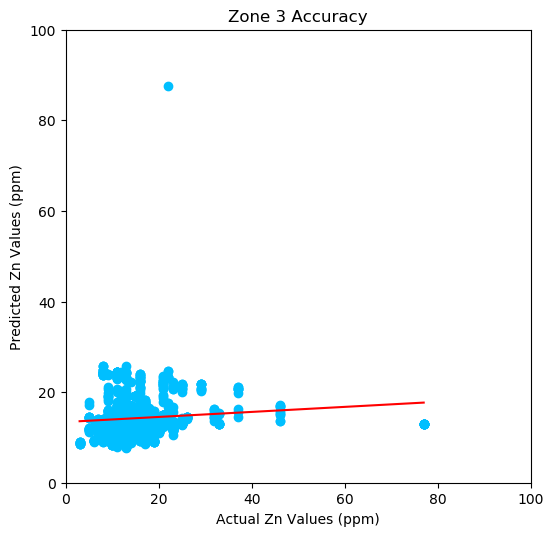

In [24]:
#Combining actual and predicted values into a DataFrame
df_results = pd.DataFrame({'Actual': y_zone3, 'Predicted': y_zone3_pred})

#Plotting actual vs predicted values
figure(num=None, figsize=(6, 6), dpi=100)
plt.scatter(df_results['Actual'], df_results['Predicted'], color='deepskyblue')
plt.xlabel('Actual Zn Values (ppm)')
plt.ylabel('Predicted Zn Values (ppm)')
plt.title('Zone 3 Accuracy')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.plot(np.unique(y_zone3), np.poly1d(np.polyfit(y_zone3, y_zone3_pred, 1))(np.unique(y_zone3)), color='red')

plt.show()

<img src="Images/3.png" />

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_zone3, y_zone3_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_zone3, y_zone3_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_zone3, y_zone3_pred)))
print('R2 Score:', metrics.r2_score(y_zone3, y_zone3_pred))

Mean Absolute Error: 5.214826949506395
Mean Squared Error: 76.0042347504908
Root Mean Squared Error: 8.718040763296006
R2 Score: -0.1508306297053681


Slightly better but it's still not correlating that well between the actual and predicted values. Ideally we want to be able to apply this model to a whole new area, so maybe we should try seeing how well we can predict zone 1 which is a bit further away from the other zones.

##### Zone 3 Train - Zone 1 Test

In [26]:
#Fitting the model
RF_zone2 = RandomForestRegressor(bootstrap= True, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50)
RF_zone2.fit(X_zone3, y_zone3)

#Returning the prediction values for the zone 2
y_zone1_pred = RF_zone2.predict(X_zone1)

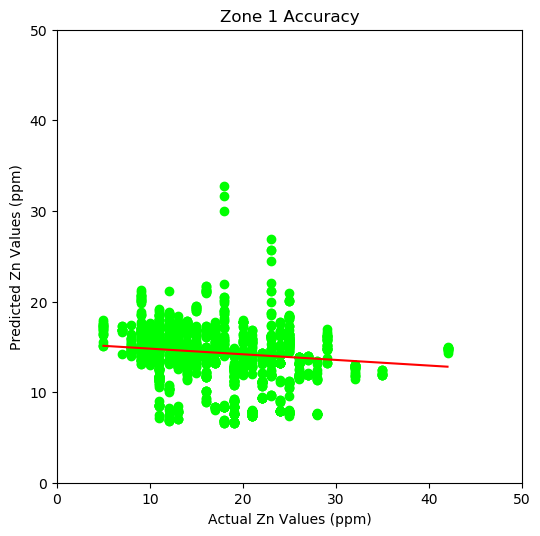

In [27]:
#Combining actual and predicted values into a DataFrame
df_results = pd.DataFrame({'Actual': y_zone1, 'Predicted': y_zone1_pred})

#Plotting actual vs predicted values
figure(num=None, figsize=(6, 6), dpi=100)
plt.scatter(df_results['Actual'], df_results['Predicted'], color='lime')
plt.xlabel('Actual Zn Values (ppm)')
plt.ylabel('Predicted Zn Values (ppm)')
plt.title('Zone 1 Accuracy')
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.plot(np.unique(y_zone1), np.poly1d(np.polyfit(y_zone1, y_zone1_pred, 1))(np.unique(y_zone1)), color='red')

plt.show()

<img src="Images/4.png" />

In [28]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_zone1, y_zone1_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_zone1, y_zone1_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_zone1, y_zone1_pred)))
print('R2 Score:', metrics.r2_score(y_zone1, y_zone1_pred))

Mean Absolute Error: 6.8095268228007715
Mean Squared Error: 75.416123436505
Root Mean Squared Error: 8.684245703370271
R2 Score: -0.8184479461247824


This isn't looking good at all. This is a bit more understandable as there is a creek running through the middle of zone 1 which would significantly affect most of the imagery, but thats just one issue. The important thing to look at here is the difference between the randomly split model and the spatially split models. Before we get into more issues with this workflow lets have a quick look at what the prediction map looks like.

### Running the Model

First we will bring the DataFrame again and prepare it for learning, apply the model we've been using for the examples, reshape the prediction and view it with matplotlib.

In [38]:
#Loading the model
df = pd.read_pickle('/Users/jackmaughan/SOIL LEARNING/DataFrames/Soil_DataFrame.pkl')

#Setting the same datatypes
df['Zone'] = df['Zone'].astype(str)
df['Lithology'] = df['Lithology'].astype(str)

#Filtering the data
df=df.filter(['Zn', 'Distance_to_Fault', 'A_Quartz', 'Distance_to_Dyke', 'K_Rad', 'Distance_to_Fold', 'H_Ferric_Iron_MGOH', 'A_Gypsum', 'A_FeO_Content', 'H_Green_Veg', 'Lithology'], axis=1)

#Splitting the inital dataframe 
y_new = np.array(df.pop('Zn').values)
X_new = np.array(df)

In [39]:
#Creating numpy arrays of the prediction (prediction) 
y_pred = RF_zone2.predict(X_new)

#Reshaping to the size of the image
y_pred = y_pred.reshape(1040, 1020).astype(float)

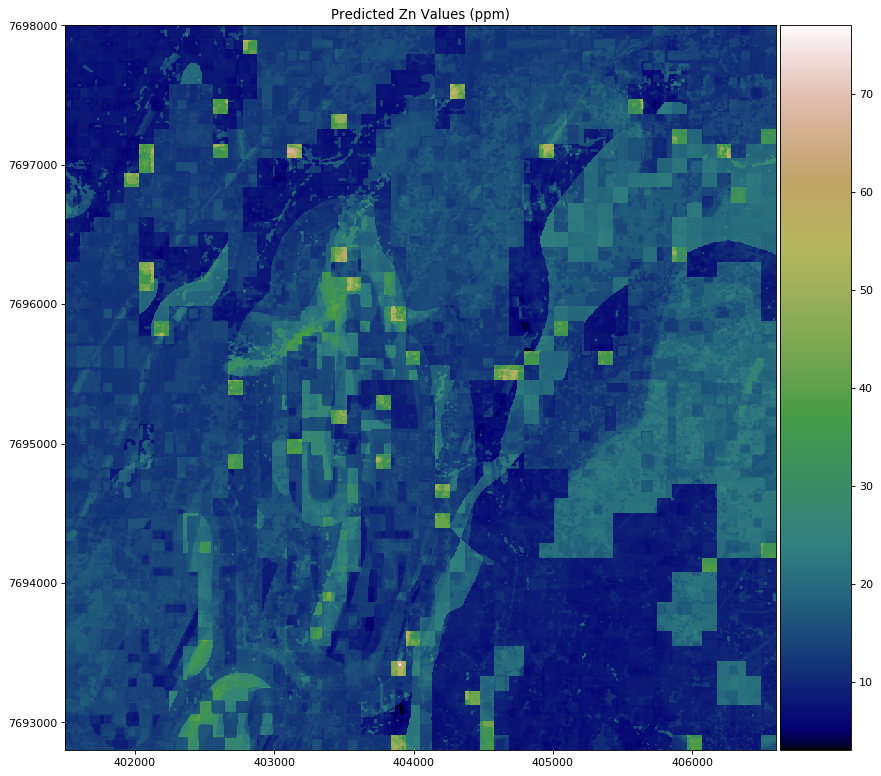

In [40]:
#Setting the image size
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

#Setting the eastings and northings boundary
bounds = [401500, 406600, 7692800, 7698000]

#Loading the image data and setting extents
plt.title('Predicted Zn Values (ppm)')
ax = plt.gca()
im = ax.imshow(y_pred, interpolation='nearest', extent=bounds, cmap='gist_earth')

#Plotting colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(im, cax=cax, format='%1.f')

#Visualising the image
plt.show()

The map shows a few trends based on some of the features but all in all is pretty bad, refelcting the models performance. That's okay though because the workflow and issues associated are the main focuses here.

<img src="Images/Scooby.png" />

# Issues

###### Geology Issues
Firstly lets have a look at the actual data we're trying to predict, the soil assays. There isn't a lot of information from the open source dataset and it doesn't say at what depth the soil was sampled, how it was sampled, and if there was any QAQC done on it. Let's assume that the soil was uniformly taken in the B horizon, depicted below, around 30-40cm deep. An issue now arises with our features, mainly the correlation between aerial imaging and the depth of sample. The radiometrics has a depth of penetration around 30-50cm depth so that should be all good (how it relates to Zn values a different story) but our Aster and Hyperspectral data now becomes questionable. As the data is only imaging and not penetrating the earth surface it does not correlate well to our B-horizon chemical composition. This is a good example of understanding your data and what you're trying to get out of it. 

<img src="Images/Horizons.png" />

###### Feature issues
Another issue is that the images were preprocessed from ASTER and Hyperspectral data to the 3 band images we got online (which we then converted to greyscale). It would've been better to gain access to the raw data and prepare our features from that.

###### Preprocessing Issues
During the feature selection process we used a spearman correlation to pick out what we put into our model. This process doesn't incorporate categorical features so instead we could have used a more rigorous technique to work out what is best for the model.


If we had access to the raw image data as mentioned above and increased our features we could also look at doing some dimensionailty reduction in the preprocessing stage. This would allow for more features to be incorporated into the model.

###### Model Issues
The Random Forest Regression algorithm we used in this example could also be substituted for something else. Because we're dealing with spatial features we could look at using a model that incorporates neighbouring pixel data such as a Convolutional Neural Network. Tweaking model paramaters even further could also help, but given the problem design the first port of call would be to reassess the features used.

<img src="Images/go.jpg" />

### Going Forward

Here are two ways this procedure could be used going forward in mineral exploration. The first way would be to continue looking at soil sampling assays, but change the features. Ideally, including a more detailed regolith map, elevation map and waterbody map as features could go a long way to increasing model accuracy. Having more information regarding the soil sampling methodology would also be beneficial. Another way to use this workflow  would be by using lag samples or rock chip samples instead of the soil sampling. This would make the aerial imagery and geophysics more significant and lead to a higher accuracy of the model. 

I hope these two options provide some insight on to how to incorporate this workflow into future geo-data science endeavours. The dataframe used in this workflow has been saved into the github repository and is readily downloadable if you wish to try and recreate this example with other elements.